# 01: PyTorch Workflow (Linear Regression)

This notebook walks through a complete beginner-friendly PyTorch workflow for linear regression.

> Reference inspiration: [PyTorch Workflow Video](https://www.youtube.com/watch?v=V_xro1bcAuA)


## 1) Imports and Setup

In this section we:
- import required libraries
- set a manual seed for reproducibility
- configure device-agnostic code (GPU if available, otherwise CPU)


In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(42)

# Device-agnostic code
device = "mps" if torch.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## 2) Create a Synthetic Linear Regression Dataset

We'll create:
- `X`: values from 0 to 1 with step size 0.02, reshaped to `(N, 1)`
- true parameters (`weight`, `bias`)
- target labels using: `y = weight * X + bias`


In [20]:
# Create input data
X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)  # shape: (50, 1)

# True parameters
weight = 0.7
bias = 0.3

# Create target data
y = weight * X + bias

print("X shape:", X.shape)
print("y shape:", y.shape)
print("First 5 samples:")
print(torch.cat((X[:5], y[:5]), dim=1))

X shape: torch.Size([50, 1])
y shape: torch.Size([50, 1])
First 5 samples:
tensor([[0.0000, 0.3000],
        [0.0200, 0.3140],
        [0.0400, 0.3280],
        [0.0600, 0.3420],
        [0.0800, 0.3560]])


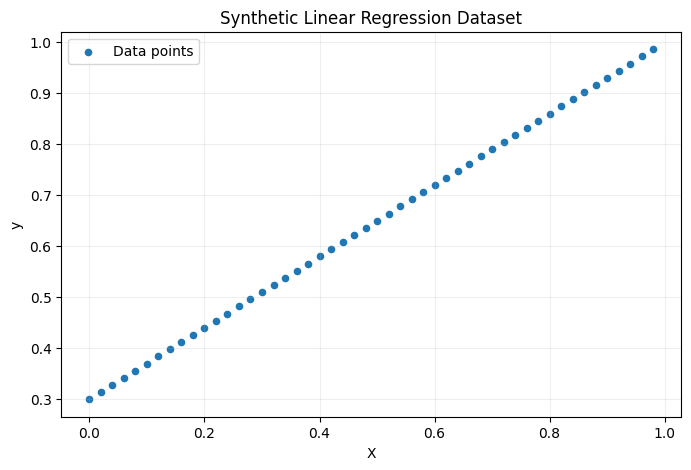

In [21]:
# Plot full dataset
plt.figure(figsize=(8, 5))
plt.scatter(X, y, s=20, c="tab:blue", label="Data points")
plt.title("Synthetic Linear Regression Dataset")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

## 3) Create Train/Test Split

We'll use an 80/20 split:
- first 80% for training
- remaining 20% for testing


In [22]:
# 80% train, 20% test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 40
Test size: 10


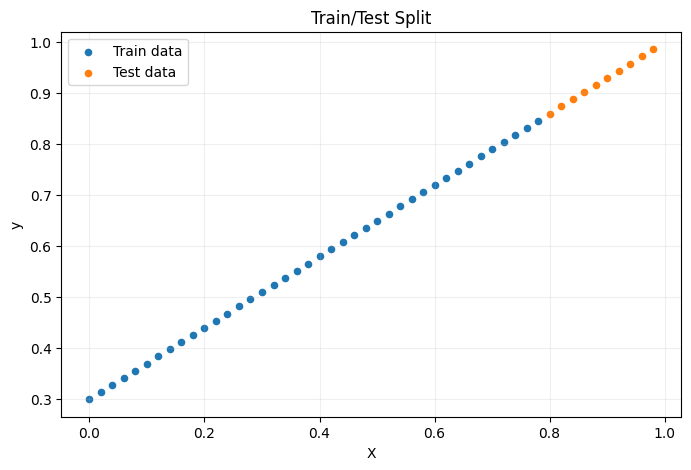

In [23]:
# Visualize train vs test data
plt.figure(figsize=(8, 5))
plt.scatter(X_train, y_train, s=20, c="tab:blue", label="Train data")
plt.scatter(X_test, y_test, s=20, c="tab:orange", label="Test data")
plt.title("Train/Test Split")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

## 4) Build a PyTorch Model

We'll create a simple model class using `nn.Module` and `nn.Linear(1, 1)`.

- The layer weight represents the slope.
- The layer bias represents the intercept.


In [24]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # One input feature -> one output feature
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x):
        # Forward pass through the linear layer
        return self.linear_layer(x)

# Create model and move to selected device
model_0 = LinearRegressionModel().to(device)
print(model_0)
print("\nModel state_dict:")
print(model_0.state_dict())

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

Model state_dict:
OrderedDict({'linear_layer.weight': tensor([[0.7645]], device='mps:0'), 'linear_layer.bias': tensor([0.8300], device='mps:0')})


### Interpreting `state_dict()`

`state_dict()` contains the model's learnable parameters:
- `linear_layer.weight`: current slope estimate
- `linear_layer.bias`: current intercept estimate

At this stage, these are random initial values (set by PyTorch initialization and seed), not yet trained to match our true values (`0.7` and `0.3`).


## 5) Make Initial Predictions (Before Training)

Let's see how the untrained model performs on the test data.

In [25]:
# Send data to device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Make predictions before training
with torch.inference_mode():
    y_preds_before = model_0(X_test)

y_preds_before[:5]

tensor([[1.4416],
        [1.4569],
        [1.4722],
        [1.4875],
        [1.5028]], device='mps:0')

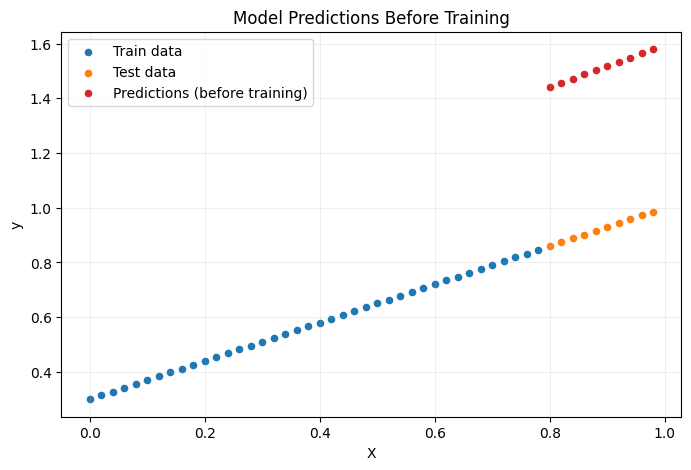

In [26]:
# Plot predictions vs actual test data (before training)
plt.figure(figsize=(8, 5))
plt.scatter(X_train.cpu(), y_train.cpu(), s=20, c="tab:blue", label="Train data")
plt.scatter(X_test.cpu(), y_test.cpu(), s=20, c="tab:orange", label="Test data")
plt.scatter(X_test.cpu(), y_preds_before.cpu(), s=20, c="tab:red", label="Predictions (before training)")
plt.title("Model Predictions Before Training")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

## 6) Set Up Loss Function and Optimizer

- **Loss function (`nn.L1Loss`)** measures prediction error (Mean Absolute Error).
- **Optimizer (`torch.optim.SGD`)** updates model parameters to reduce loss.


In [27]:
# Loss function (criterion)
loss_fn = nn.L1Loss()

# Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

## 7) Write a Full Training Loop

Training loop steps per epoch:
1. `model.train()`
2. Forward pass on training data
3. Compute training loss
4. `optimizer.zero_grad()`
5. `loss.backward()`
6. `optimizer.step()`

Then evaluate on test data with:
- `model.eval()`
- `torch.inference_mode()`
- compute test loss


In [28]:
# Training configuration
epochs = 200

# Track loss values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    # --------------------
    # Training
    # --------------------
    model_0.train()

    # Forward pass
    y_pred = model_0(X_train)

    # Compute train loss
    loss = loss_fn(y_pred, y_train)

    # Zero gradients
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Update parameters
    optimizer.step()

    # --------------------
    # Evaluation
    # --------------------
    model_0.eval()
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)

    # Store values for plotting
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().cpu().item())
        test_loss_values.append(test_loss.detach().cpu().item())
        print(f"Epoch: {epoch:03d} | Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f}")

Epoch: 000 | Train Loss: 0.5552 | Test Loss: 0.5740
Epoch: 010 | Train Loss: 0.4400 | Test Loss: 0.4393
Epoch: 020 | Train Loss: 0.3248 | Test Loss: 0.3046
Epoch: 030 | Train Loss: 0.2095 | Test Loss: 0.1698
Epoch: 040 | Train Loss: 0.0943 | Test Loss: 0.0351
Epoch: 050 | Train Loss: 0.0239 | Test Loss: 0.0478
Epoch: 060 | Train Loss: 0.0200 | Test Loss: 0.0458
Epoch: 070 | Train Loss: 0.0165 | Test Loss: 0.0375
Epoch: 080 | Train Loss: 0.0131 | Test Loss: 0.0299
Epoch: 090 | Train Loss: 0.0097 | Test Loss: 0.0217
Epoch: 100 | Train Loss: 0.0062 | Test Loss: 0.0141
Epoch: 110 | Train Loss: 0.0028 | Test Loss: 0.0058
Epoch: 120 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch: 130 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch: 140 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch: 150 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch: 160 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch: 170 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch: 180 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch: 190 |

## 8) Plot Loss Curves

Now we'll visualize how training and test loss change over epochs.

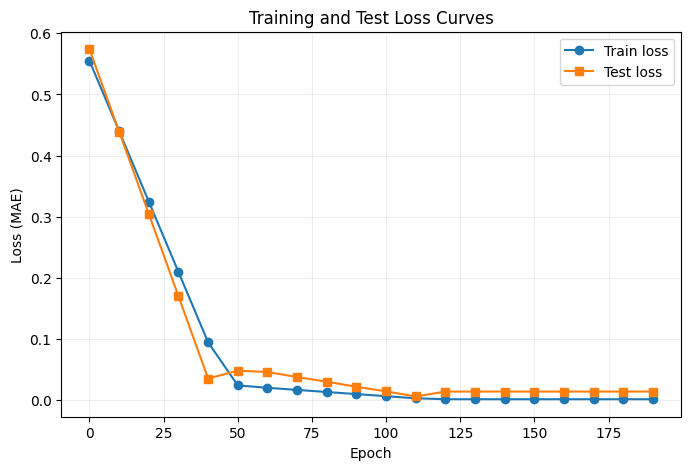

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(epoch_count, train_loss_values, label="Train loss", marker="o")
plt.plot(epoch_count, test_loss_values, label="Test loss", marker="s")
plt.title("Training and Test Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

## 9) Evaluate Final Predictions

Let's compare final model predictions with the ground truth test data.

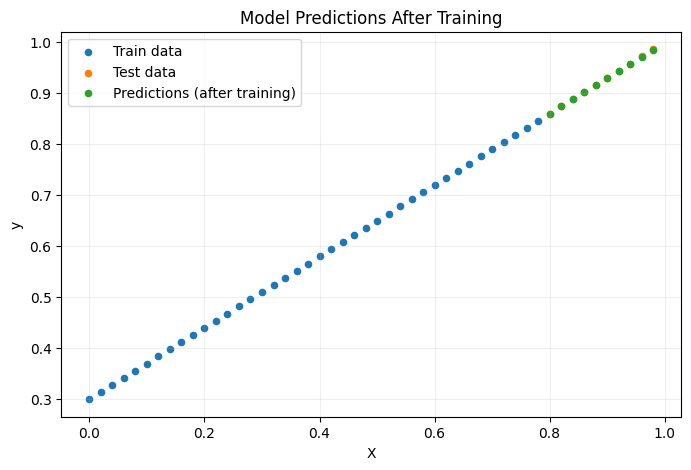

In [30]:
model_0.eval()
with torch.inference_mode():
    y_preds_after = model_0(X_test)

plt.figure(figsize=(8, 5))
plt.scatter(X_train.cpu(), y_train.cpu(), s=20, c="tab:blue", label="Train data")
plt.scatter(X_test.cpu(), y_test.cpu(), s=20, c="tab:orange", label="Test data")
plt.scatter(X_test.cpu(), y_preds_after.cpu(), s=20, c="tab:green", label="Predictions (after training)")
plt.title("Model Predictions After Training")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

## 10) Save and Load the Model

We'll save the trained `state_dict`, load it into a fresh model instance, and verify predictions match.

In [33]:
# Save model state_dict
MODEL_SAVE_PATH = "models.pths"
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to: {MODEL_SAVE_PATH}")

Model saved to: models.pths


In [34]:
# Create a new instance and load saved parameters
loaded_model = LinearRegressionModel().to(device)
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
loaded_model.eval()

# Verify loaded model predictions match original model predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)

are_equal = torch.allclose(y_preds_after, loaded_model_preds)
print("Do original and loaded model predictions match?", are_equal)

# Optional: show a quick parameter comparison
print("\nOriginal model state_dict:")
print(model_0.state_dict())
print("\nLoaded model state_dict:")
print(loaded_model.state_dict())

Do original and loaded model predictions match? True

Original model state_dict:
OrderedDict({'linear_layer.weight': tensor([[0.6968]], device='mps:0'), 'linear_layer.bias': tensor([0.3025], device='mps:0')})

Loaded model state_dict:
OrderedDict({'linear_layer.weight': tensor([[0.6968]], device='mps:0'), 'linear_layer.bias': tensor([0.3025], device='mps:0')})


## Notebook Complete

You have now built, trained, evaluated, saved, and loaded a PyTorch linear regression model end-to-end.